In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from pathlib import Path
from sklearn.cluster import KMeans
from social_dynamics import autoencoder_utils
import tensorflow as tf
import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

root_path = utils.determine_root_path()

In [2]:
autoencoder_clustering_path = root_path.joinpath("large_autoencoder_clustering")
autoencoder_results_path = autoencoder_clustering_path.joinpath("autoencoders_results")
model_input_types = ["cnn-complete", "cnn-cut", "dnn-complete", "dnn-cut"]

results = utils.load_autoencoder_exploration_results(path=autoencoder_clustering_path,
                                                     model_input_types=model_input_types)

series_dir_path = Path("/home/htc/fmalerba/experiments_results/2_opt-h_luzie-alpha_beta_gamma_delta_expl-0.0001t")
datasets, n_agents, n_options = autoencoder_utils.load_all_datasets(series_dir=series_dir_path,
                                                                    downsampling=4)
y_trues = dict([(key, np.array(list(datasets[key].as_numpy_iterator()))[:, 1])
                for key in datasets])
del datasets

In [3]:
model_path = autoencoder_results_path.joinpath(
    utils.select_autoencoder_model(model_input_type='cnn-cut', results=results, mode='mse', start=6, end=7))
#model_path = autoencoder_results_path.joinpath('cnn-cut-1')

model_input_type = "-".join(model_path.name.split('-')[:2])

embeddings = np.load(model_path.joinpath("embeddings.npy"))
embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))
y_pred = np.load(model_path.joinpath("predictions.npy"))

# K-Means Clustering

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
labels = kmeans.labels_
one_hot_encodings = tf.one_hot(indices=labels, depth=n_clusters).numpy()
pca_plotter = utils.PCAPlotter(X=embeddings, y=one_hot_encodings, classes=[str(i) for i in range(n_clusters)])
pca_plotter.plotPCA_3D()

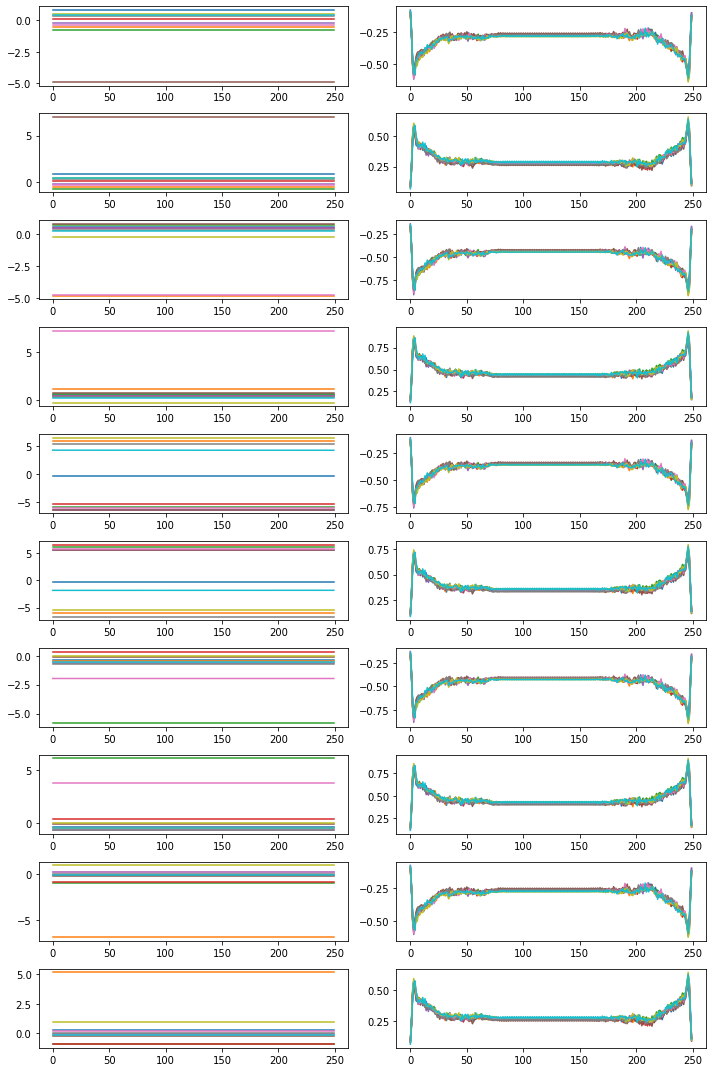

In [11]:
trues, preds = autoencoder_utils.select_predictions(mode='clusters', n_to_sample=5, y_true=y_trues[model_input_type],
                                                    y_pred=y_pred, clusters=labels, selected_cluster=3)

plt.figure(num=1, figsize=(10, 15))
plt.title(model_path.name)
autoencoder_utils.plot_preds(fig_num=1,
                             y_true=trues,
                             y_pred=preds,
                             n_agents=n_agents,
                             n_options=n_options)
plt.tight_layout()
plt.show()